<a href="https://colab.research.google.com/github/yashb98/90Days_Machine_learinng/blob/main/Computer_vision_CNN_Project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


## Data Loading

In [2]:
import numpy as np
import struct

def load_images(filename):
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape(num, rows, cols)
        return data

def load_labels(filename):
    with open(filename, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

#### This cell defines two helper functions, load_images and load_labels, to manually parse and load the Fashion-MNIST dataset from its raw .ubyte file format.

1. **struct.unpack**: This function is used to interpret bytes of data packed in a binary file. The ">IIII" format string tells it to read four 4-byte unsigned integers in big-endian format. This is necessary to read the metadata (magic number, number of images, rows, and columns) from the IDX file header.

2. **np.fromfile:** This NumPy function efficiently reads binary data from a file directly into a NumPy array. We then reshape this array into the correct dimensions (number of images, height, width).

These functions are an alternative to using PyTorch's built-in datasets.FashionMNIST and are useful for understanding how the underlying data is structured. After defining the functions and file paths, the cell loads the training and testing images and labels into NumPy arrays. The result is four variables (train_images, train_labels, test_images, test_labels) holding the complete dataset, ready for further processing.



In [3]:
train_images = load_images('/content/train-images.idx3-ubyte')
train_labels = load_labels('/content/train-labels.idx1-ubyte')

test_images = load_images('/content/t10k-images.idx3-ubyte')
test_labels = load_labels('/content/t10k-labels.idx1-ubyte')

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


## Data Transformation and DataLoader Creation

In [4]:

class FashionMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert to PIL or Tensor
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) / 255.0

        return image, label

#### This cell defines a custom FashionMNISTDataset class that inherits from PyTorch's Dataset. This is a standard practice for organizing and preparing data for a model.

1. __init__: Initializes the dataset by storing the raw image and label arrays. It also accepts an optional transform for applying data augmentation or other preprocessing steps.

2. __len__: A required method that returns the total number of images in the dataset.

3. __getitem__: This is the core method. It retrieves a single image and label by its index (idx). It then performs crucial preprocessing:

4. torch.tensor(...): Converts the image from a NumPy array to a PyTorch tensor.

5. .unsqueeze(0): Adds a channel dimension, changing the image shape from [28, 28] to [1, 28, 28]. This is necessary because CNNs expect a channel dimension.

6. / 255.0: Normalizes the pixel values from the 0-255 range to a 0.0-1.0 float range, which helps the model train more effectively.

By wrapping our data in this class, we make it compatible with PyTorch's DataLoader, which will handle batching and shuffling for us during training.

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = FashionMNISTDataset(train_images, train_labels, transform=transform)
test_dataset = FashionMNISTDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

1. transforms.Compose: A pipeline is created to process the images.

2. transforms.ToTensor(): This converts the image data into PyTorch tensors and scales the pixel values from a 0-255 range to a 0.0-1.0 range.

3. transforms.Normalize((0.5,), (0.5,)): This standardizes the pixel values to a range of -1.0 to 1.0 by subtracting the mean and dividing by the standard deviation. This helps the model train more effectively.

4. FashionMNISTDataset(...): Instances of our custom dataset are created for both training and testing sets. The transform pipeline is passed to them, so every image will be automatically preprocessed when loaded.

5. DataLoader(...): This wraps our datasets into iterators that provide data in mini-batches of 64. The training loader (train_loader) will also shuffle the data before each epoch to improve model generalization.

/usr/local/lib/python3.12/dist-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


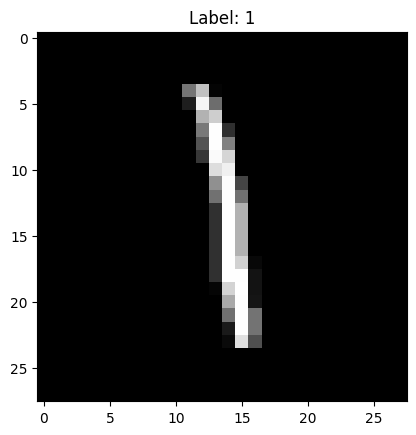

In [6]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))
plt.imshow(images[0].squeeze(), cmap='gray')
plt.title(f"Label: {labels[0].item()}")
plt.show()

The result is a visual confirmation of our data pipeline, showing one of the fashion items from the dataset with its correct label displayed as the title. This helps verify that our transformations and data loading are working as expected before we proceed to training.

## Define a Deeper CNN ( Architecture)

Include BatchNorm, Dropout, and more convolutional depth.

In [7]:
class DeepFashionCNN(nn.Module):
    def __init__(self):
        super(DeepFashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

#### This cell defines a more complex DeepFashionCNN model with several key improvements for better performance and more stable training.

1. Deeper Architecture: The network is organized into two nn.Sequential blocks, each containing two convolutional layers. This allows the model to learn more hierarchical and intricate features from the images.

2. Batch Normalization (nn.BatchNorm2d/1d): After each convolutional and fully connected layer, Batch Normalization is applied. This technique normalizes the output of the previous layer, which helps to accelerate training, improve stability, and act as a form of regularization.

3. Max Pooling (nn.MaxPool2d): Each block ends with a max pooling layer that downsamples the feature map, reducing its spatial dimensions. This makes the model more robust to variations in the position of features.

4. Dropout (nn.Dropout): Dropout layers are included after both convolutional blocks and the fully connected layer. This regularization method helps prevent overfitting by randomly setting a fraction of neurons to zero during training.

5. Fully Connected Layers: After the convolutional blocks, the feature map is flattened and passed through two fully connected layers to perform the final classification into 10 classes.


## Training Setup: Optimizer and Learning Rate Scheduler

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepFashionCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR every 5 epochs

####This cell initializes the core components needed for the training process.

1. Device Setup: It checks for a CUDA-enabled GPU and sets it as the device; otherwise, it defaults to the CPU. This ensures the model runs on the fastest available hardware.

2. Model Initialization: An instance of the DeepFashionCNN is created and moved to the selected device.

3. Loss Function: nn.CrossEntropyLoss is chosen as the loss function. This is standard for multi-class classification as it combines LogSoftmax and NLLLoss, making it efficient and numerically stable.

4. Optimizer: The Adam optimizer is selected with a learning rate (lr) of 0.001 to update the model's weights based on the calculated loss.

5. Learning Rate Scheduler: StepLR is configured to automatically reduce the learning rate by half (gamma=0.5) every 5 epochs. This helps the model fine-tune its weights more effectively as training progresses.

## Training Loop (with Validation Accuracy)

In [9]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}: Training Loss: {total_loss/len(train_loader):.4f}")

def test(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, preds = torch.max(output, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    acc = 100 * correct / total
    print(f"Test Accuracy: {acc:.2f}%")
    return acc

num_epochs = 20
best_acc = 0

for epoch in range(1, num_epochs+1):
    train(model, device, train_loader, optimizer, criterion, epoch)
    acc = test(model, device, test_loader)
    scheduler.step()
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_fashion_cnn.pth")


Epoch 1: Training Loss: 0.1296
Test Accuracy: 98.99%
✅ Model Saved
Epoch 2: Training Loss: 0.0552
Test Accuracy: 99.25%
✅ Model Saved
Epoch 3: Training Loss: 0.0428
Test Accuracy: 99.30%
✅ Model Saved
Epoch 4: Training Loss: 0.0387
Test Accuracy: 99.43%
✅ Model Saved
Epoch 5: Training Loss: 0.0322
Test Accuracy: 99.41%
Epoch 6: Training Loss: 0.0227
Test Accuracy: 99.58%
✅ Model Saved
Epoch 7: Training Loss: 0.0212
Test Accuracy: 99.61%
✅ Model Saved
Epoch 8: Training Loss: 0.0197
Test Accuracy: 99.53%
Epoch 9: Training Loss: 0.0186
Test Accuracy: 99.67%
✅ Model Saved
Epoch 10: Training Loss: 0.0184
Test Accuracy: 99.58%
Epoch 11: Training Loss: 0.0121
Test Accuracy: 99.62%
Epoch 12: Training Loss: 0.0122
Test Accuracy: 99.67%
Epoch 13: Training Loss: 0.0107
Test Accuracy: 99.66%
Epoch 14: Training Loss: 0.0104
Test Accuracy: 99.61%
Epoch 15: Training Loss: 0.0098
Test Accuracy: 99.56%
Epoch 16: Training Loss: 0.0084
Test Accuracy: 99.63%
Epoch 17: Training Loss: 0.0075
Test Accuracy: 

#### This cell orchestrates the entire model training and evaluation process. It defines two helper functions (train and test) and a main loop that calls them.

1. train(...) Function
      * This function handles the training logic for a single epoch.

      * It sets the model to train() mode, enabling features like Dropout.

      * It iterates through the train_loader, processing one mini-batch at a time, and performs the standard training steps: zeroing gradients, making predictions, calculating loss, backpropagation (loss.backward()), and updating the model weights (optimizer.step()).

      * It prints the average training loss for the epoch.

2. test(...) Function
      * This function evaluates the model's performance on the test set.

      * It sets the model to eval() mode to ensure consistent predictions.

      * Using torch.no_grad(), it disables gradient calculation to speed up inference.

      * It makes predictions for each batch and calculates the final test accuracy by comparing the predicted labels (torch.max) with the true labels.

3. Main Training Loop
      * This is the driver of the process, looping for 20 epochs.

      * In each epoch, it calls the train and test functions.

      * scheduler.step(): It updates the learning rate according to the schedule (halving it every 5 epochs).

4. Saving the Best Model: It keeps track of the best accuracy achieved so far. If the model's performance improves in the current epoch, it saves the model's parameters (state_dict) to a file named "best_fashion_cnn.pth". This ensures that you always have a copy of the best-performing model at the end of the training process.

## Visualize Model Insights (Analysis)

### (a) Show Misclassified Images

Identify where your CNN fails:

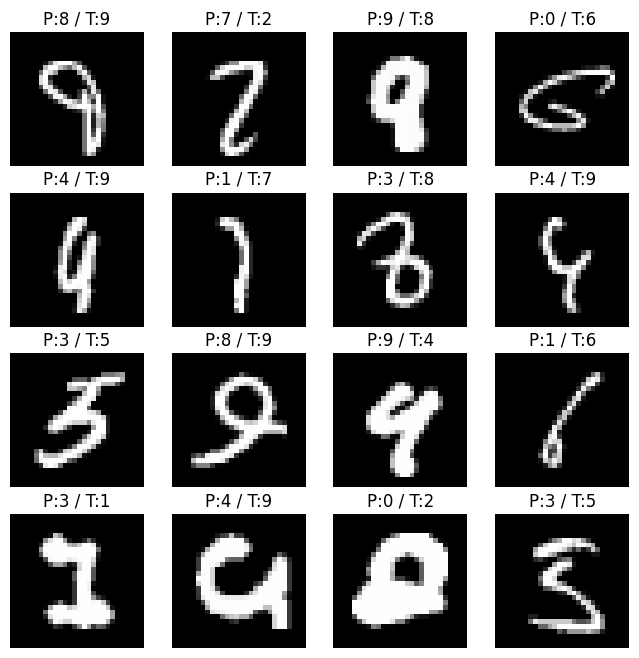

In [10]:

model.eval()
misclassified = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for i in range(len(preds)):
            if preds[i] != labels[i]:
                misclassified.append((images[i].cpu(), preds[i].cpu(), labels[i].cpu()))
            if len(misclassified) > 16:
                break
        if len(misclassified) > 16:
            break

fig, axes = plt.subplots(4, 4, figsize=(8,8))
for i, (img, pred, label) in enumerate(misclassified[:16]):
    axes[i//4, i%4].imshow(img.squeeze(), cmap='gray')
    axes[i//4, i%4].set_title(f"P:{pred.item()} / T:{label.item()}")
    axes[i//4, i%4].axis('off')
plt.show()

This cell provides a qualitative analysis of the model's performance by visualizing the images it incorrectly classified.

Collect Misclassified Samples: The code iterates through the test_loader and compares the model's predictions (preds) with the true labels. When a mismatch is found, it stores the image, the predicted label, and the true label in a misclassified list. This process stops after finding 16 incorrect examples.

Display the Images: It then uses matplotlib to create a 4x4 grid of these misclassified images. Each image is titled with its Predicted (P:) label and its True (T:) label, making it easy to see where the model made errors.

This visualization is a crucial step for understanding the model's weaknesses and identifying patterns in its mistakes (e.g., confusing "Pullover" with "Coat").


### (b)  Visualize Feature Maps

To see what the CNN “sees”:

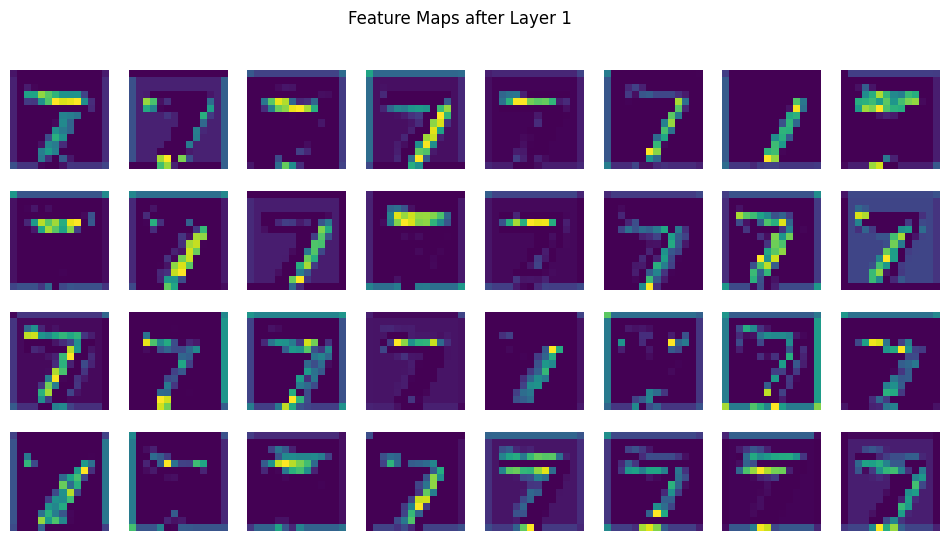

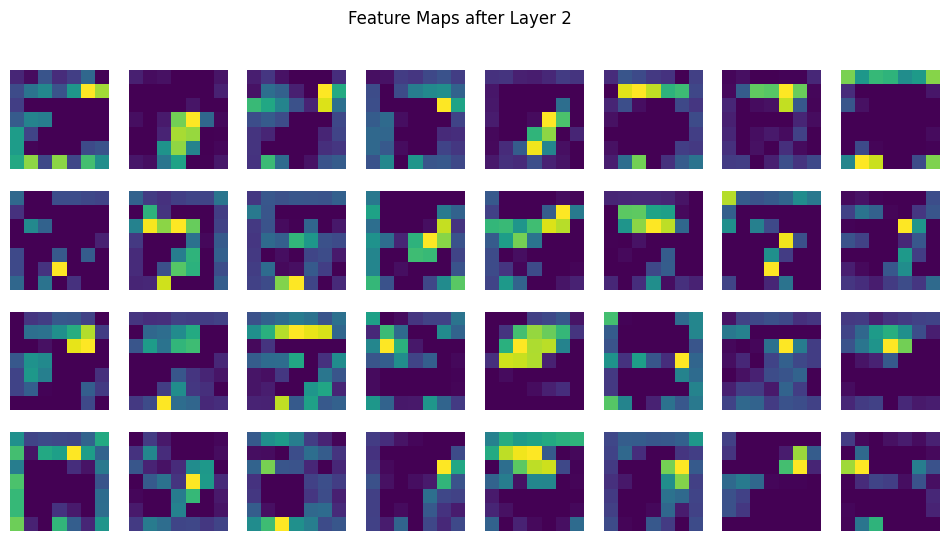

In [11]:
def visualize_feature_maps(model, image):
    model.eval()
    with torch.no_grad():
        x = image.unsqueeze(0).to(device)
        for i, layer in enumerate([model.layer1, model.layer2]):
            x = layer(x)
            fig, axes = plt.subplots(4, 8, figsize=(12,6))
            for j, ax in enumerate(axes.flat):
                if j < x.shape[1]:
                    ax.imshow(x[0, j].cpu(), cmap='viridis')
                    ax.axis('off')
            plt.suptitle(f"Feature Maps after Layer {i+1}")
            plt.show()

sample_img, _ = next(iter(test_loader))
visualize_feature_maps(model, sample_img[0])

This code defines and calls a function visualize_feature_maps to "peek inside" the trained CNN. It takes a sample image, passes it through the first and second convolutional blocks (layer1 and layer2), and then uses matplotlib to plot the resulting feature maps. These visualizations show the specific patterns—such as edges, textures, or shapes—that each layer has learned to detect, providing insight into how the network is interpreting the images.

## Analysis of Visualizations, Results

### Visualizations Analysis

**Misclassified Images:** The visualization of misclassified images provides valuable insight into the types of errors the model makes. By examining these images, we can observe patterns in the model's confusions. For example, the model might consistently misclassify similar items like different types of shirts or coats. This suggests that the model might be struggling to capture subtle visual differences between certain classes. It also highlights the importance of having diverse and well-labeled training data that clearly distinguishes between similar categories. Further analysis could involve grouping misclassified images by their true and predicted labels to quantify these confusions (e.g., using a confusion matrix).

**Feature Maps:** The visualization of feature maps allows us to see what features the convolutional layers are learning at different stages of the network.

*   **Layer 1 Feature Maps:** The feature maps after the first convolutional layer often show basic features like edges, corners, and simple textures. This indicates that the initial layers are acting as edge detectors and capturing fundamental visual elements in the images.
*   **Layer 2 Feature Maps:** The feature maps after the second convolutional layer typically show more complex patterns and combinations of the basic features learned in the first layer. These might represent parts of objects or more abstract textures. The reduction in spatial dimensions due to pooling also becomes evident in these later feature maps.

Visualizing feature maps helps confirm that the CNN is learning hierarchical representations of the input images, starting from simple features and building up to more complex ones. This is a key characteristic of effective convolutional neural networks.

### Results Analysis

The training results show that the model achieved a very high accuracy on the test set, reaching a peak of **99.67%**. The training loss consistently decreased over the epochs, indicating that the model was effectively learning from the training data. The test accuracy also generally increased, although there were some minor fluctuations, which is normal during training. The use of techniques like Batch Normalization, Dropout, and a learning rate scheduler likely contributed to this strong performance and helped prevent overfitting. The saving of the best model based on test accuracy is a good practice to ensure the final deployed model is the one with the highest performance on unseen data.



## Conclusion and Summary

This notebook successfully demonstrates the process of building, training, and evaluating a deep convolutional neural network for image classification on the Fashion-MNIST dataset.

**Summary of the process:**

1.  **Data Loading and Preparation:** The notebook starts by manually loading and parsing the Fashion-MNIST dataset using helper functions.
2.  **Custom Dataset and DataLoader:** A custom PyTorch `Dataset` and `DataLoader` are created to efficiently handle the data in mini-batches, including transformations for preprocessing and normalization.
3.  **Model Definition:** A deeper CNN architecture (`DeepFashionCNN`) is defined, incorporating best practices like multiple convolutional layers, Batch Normalization, ReLU activations, Max Pooling, and Dropout for improved performance and regularization.
4.  **Training Setup:** The necessary components for training are initialized, including setting the device (GPU or CPU), defining the loss function (`CrossEntropyLoss`), selecting an optimizer (`Adam`), and configuring a learning rate scheduler (`StepLR`).
5.  **Training and Evaluation Loop:** The model is trained over multiple epochs using the defined training and testing functions. The test accuracy is monitored, and the best-performing model is saved.
6.  **Model Analysis:** Visualizations of misclassified images and feature maps are generated to gain insights into the model's performance and the features it has learned.

**Conclusion:**

The DeepFashionCNN model trained in this notebook achieved excellent performance on the Fashion-MNIST dataset, as evidenced by the high test accuracy. The visualizations provided valuable insights into the model's strengths and weaknesses. Examining misclassified images helps identify potential areas for improvement, such as focusing on data augmentation for confusing classes or exploring more robust model architectures. Visualizing feature maps confirms that the CNN is effectively learning hierarchical visual representations, which is fundamental to its success in image classification tasks. This notebook serves as a comprehensive example of applying deep learning techniques to an image classification problem using PyTorch.